In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Cargar el archivo NPY
intervals = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/intervals_1601.npy')
intervals_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/intervals_ref_1601.npy')
labels_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/labels_1601.npy')
labels_1601_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/labels_ref_1601.npy')
test_intervals_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/test_intervals_1601.npy')
test_labels_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/test_labels_1601.npy')
x_out_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_1601.npy')
x_out_1601_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_ref_1601.npy')
x_out_1601_test = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_test_1601.npy')

print('intervals:', intervals.shape)
print('intervals_ref:', intervals_ref.shape)
print('labels_1601:', labels_1601.shape)
print('labels_1601_ref:', labels_1601_ref.shape)
print('test_intervals_1601:', test_intervals_1601.shape)
print('test_labels_1601:', test_labels_1601.shape)
print('x_out_1601:', x_out_1601.shape)
print('x_out_1601_ref:', x_out_1601_ref.shape)
print('x_out_1601_test:', x_out_1601_test.shape)


C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_22800\1249299595.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


intervals: (4800,)
intervals_ref: (80,)
labels_1601: (4800,)
labels_1601_ref: (80,)
test_intervals_1601: (2400,)
test_labels_1601: (2400,)
x_out_1601: (4800, 1601, 128, 1)
x_out_1601_ref: (80, 1601, 128, 1)
x_out_1601_test: (2400, 1601, 128, 1)


In [2]:
import tensorflow as tf
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Convert string labels to numerical labels
label_encoder = LabelEncoder()
labels_1601_categorical = label_encoder.fit_transform(labels_1601)
labels_1601_categorical_test = label_encoder.transform(test_labels_1601)

In [3]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear directorio para guardar las imágenes aumentadas
save_dir = 'augmented_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Crear un DataFrame para almacenar las etiquetas
augmented_labels = pd.DataFrame(columns=['filename', 'label'])

# Crear un generador de datos con aumentaciones
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Ajuste del generador de datos a los datos de entrenamiento
datagen.fit(x_out_1601)

# Configurar el generador para guardar imágenes en disco
batch_size = 32
image_count = 0
num_batches = 150  # Número de lotes necesarios para generar 4800 imágenes

# Listas para almacenar las imágenes y etiquetas generadas
augmented_images = []
augmented_labels_list = []
augmented_intervals = []

# Supongamos que intervals es un array de numpy con la misma longitud que x_out_1601 y labels_1601
# Ejemplo: intervals = np.array([1, 2, 3, ...])

for i, (batch_x, batch_y) in enumerate(datagen.flow(x_out_1601, labels_1601, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='png')):
    for j in range(batch_size):
        # Construir el nombre del archivo de la imagen guardada
        filename = f'aug_{image_count + j}.png'
        # Obtener la etiqueta correspondiente
        label = batch_y[j]
        # Obtener el intervalo correspondiente (suponiendo que se mantienen los mismos intervalos)
        interval = intervals[image_count + j % len(intervals)]
        # Guardar las imágenes, etiquetas e intervalos en listas
        augmented_images.append(batch_x[j])
        augmented_labels_list.append(label)
        augmented_intervals.append(interval)
        # Crear un DataFrame temporal para la nueva fila
        new_row = pd.DataFrame({'filename': [filename], 'label': [label], 'interval': [interval]})
        # Concatenar el DataFrame temporal con el DataFrame principal
        augmented_labels = pd.concat([augmented_labels, new_row], ignore_index=True)
    image_count += batch_size
    if i >= num_batches - 1:  # Generar exactamente 150 lotes
        break

# Convertir las listas de imágenes, etiquetas e intervalos a arrays de numpy
augmented_images = np.array(augmented_images)
augmented_labels_array = np.array(augmented_labels_list)
augmented_intervals_array = np.array(augmented_intervals)

# Concatenar las imágenes, etiquetas e intervalos originales con las aumentadas
x_combined = np.concatenate((x_out_1601, augmented_images), axis=0)
labels_combined = np.concatenate((labels_1601, augmented_labels_array), axis=0)
intervals_combined = np.concatenate((intervals, augmented_intervals_array), axis=0)

# Guardar las etiquetas y intervalos en un archivo CSV
augmented_labels.to_csv(os.path.join(save_dir, 'augmented_labels.csv'), index=False)

print(f"Total de imágenes originales: {len(x_out_1601)}")
print(f"Total de imágenes generadas: {len(augmented_images)}")
print(f"Total de imágenes combinadas: {len(x_combined)}")
print(f"Total de intervalos combinados: {len(intervals_combined)}")


Total de imágenes originales: 4800
Total de imágenes generadas: 4800
Total de imágenes combinadas: 9600
Total de intervalos combinados: 9600


In [4]:
import pandas as pd
import numpy as np

# Crear un DataFrame
df = pd.DataFrame({
    'intervals': intervals_combined,   # Asumimos que 'intervals' está previamente cargado
    'labels_1601': labels_combined  # Asumimos que 'labels_1601' está previamente cargado
})

# Combinar 'intervals' y 'labels_1601' en una columna y factorizar para asignar un identificador único
df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]

# Usar groupby para agrupar por categoría y recoger los índices en listas
positions_by_category = df.groupby('category').apply(lambda x: x.index.tolist()).tolist()

# Ordenar cada lista de posiciones de forma descendente
positions_by_category_sorted = [sorted(positions, reverse=True) for positions in positions_by_category]

# Convertir la lista de listas en un array de numpy con dtype=object para manejar listas de diferentes longitudes
x_train_a_position = np.array(positions_by_category, dtype=object)
x_train_b_position = np.array(positions_by_category_sorted, dtype=object)

# Opcionalmente, aplana las listas si es necesario para alguna otra operación
indices_x_train_a_position = [item for sublist in x_train_a_position for item in sublist]
indices_x_train_b_position = [item for sublist in x_train_b_position for item in sublist]


C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_21488\2801379147.py:11: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]
C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_21488\2801379147.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  positions_by_category = df.groupby('category').apply(lambda x: x.index.tolist()).tolist()


In [5]:
df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]

C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_21488\2544489754.py:1: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]


In [6]:
import pandas as pd
import numpy as np

# Crear un DataFrame
df_2 = pd.DataFrame({
    'test_intervals_1601': test_intervals_1601,
    'test_labels_1601': test_labels_1601
})

# Combinar 'test_intervals_1601' y 'test_labels_1601' en una columna y factorizar para asignar un identificador único
df_2['category'] = pd.factorize(list(zip(df_2['test_intervals_1601'], df_2['test_labels_1601'])))[0]

# Usar groupby para agrupar por categoría y recoger los índices en listas
positions_by_category_y = df_2.groupby('category').apply(lambda x: x.index.tolist()).tolist()

# Ordenar cada lista de posiciones de forma descendente
positions_by_category_sorted_y = [sorted(positions, reverse=True) for positions in positions_by_category_y]

# Convertir la lista de listas en un array de numpy con dtype=object para manejar listas de diferentes longitudes
y_test_a_position = np.array(positions_by_category_y, dtype=object)
y_test_b_position = np.array(positions_by_category_sorted_y, dtype=object)

# Opcionalmente, aplana las listas si es necesario para alguna otra operación
indices_y_test_a_position = [item for sublist in y_test_a_position for item in sublist]
indices_y_test_b_position = [item for sublist in y_test_b_position for item in sublist]

C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_21488\4017899764.py:11: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df_2['category'] = pd.factorize(list(zip(df_2['test_intervals_1601'], df_2['test_labels_1601'])))[0]
C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_21488\4017899764.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  positions_by_category_y = df_2.groupby('category').apply(lambda x: x.index.tolist()).tolist()


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

def build_autoencoder():
    # Define la entrada con el nuevo tamaño de imagen
    input_img = Input(shape=(1600, 128, 1))

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Construir el modelo
autoencoder = build_autoencoder()
autoencoder.summary()



c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1600, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1600, 128, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1600, 128, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 128, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 800, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 800, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 800, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 400, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 400, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 32, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 200, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 400, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 400, 32, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 400, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 400, 32, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 800, 64, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 800, 64, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 800, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 1600, 128, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 334,593 (1.28 MB)

 Trainable params: 333,697 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
# Normalizar los datos de entrenamiento y prueba
x_combined = x_combined.astype('float32') / 255.0
x_out_1601_test = x_out_1601_test.astype('float32') / 255.0

In [9]:
# Reordenar los datasets según los índices proporcionados
x_train = x_combined[indices_x_train_a_position]
x_train_b = x_combined[indices_x_train_b_position]
x_test = x_out_1601_test[indices_y_test_a_position]
x_test_b = x_out_1601_test[indices_y_test_b_position]

# Recortar un píxel de la parte superior de cada imagen en todos los datasets
x_train = x_train[:, 1:1601, :, :]
x_train_b = x_train_b[:, 1:1601, :, :]
x_test = x_test[:, 1:1601, :, :]
x_test_b = x_test_b[:, 1:1601, :, :]

In [10]:
print("Dimensiones de x_train:", x_train.shape)
print("Dimensiones de x_train_b:", x_train_b.shape)
print("Dimensiones de x_test:", x_test.shape)
print("Dimensiones de x_test_b:", x_test_b.shape)


Dimensiones de x_train: (9600, 1600, 128, 1)
Dimensiones de x_train_b: (9600, 1600, 128, 1)
Dimensiones de x_test: (2400, 1600, 128, 1)
Dimensiones de x_test_b: (2400, 1600, 128, 1)


In [11]:
def filter_cwt(X, thr):
    X_copy = X.copy()
    X_copy[X_copy < thr] = 0
    return X_copy

In [12]:
thr = 0.1
x_train = filter_cwt(x_train, thr)
x_train_b  = filter_cwt(x_train_b , thr)
x_test = filter_cwt(x_test, thr)
x_test_b = filter_cwt(x_test_b, thr)

Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0889 
Epoch 1: val_loss improved from inf to 0.03279, saving model to autoencoder_data_aumentation_1.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 4519s 15s/step - loss: 0.0888 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0374 
Epoch 2: val_loss did not improve from 0.03279
300/300 ━━━━━━━━━━━━━━━━━━━━ 4280s 14s/step - loss: 0.0374 - val_loss: 0.0347 - learning_rate: 0.0010
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0363 
Epoch 3: val_loss did not improve from 0.03279
300/300 ━━━━━━━━━━━━━━━━━━━━ 4275s 14s/step - loss: 0.0363 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0356 
Epoch 4: val_loss did not improve from 0.03279
300/300 ━━━━━━━━━━━━━━━━━━━━ 4280s 14s/step - loss: 0.0356 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0357 
Epoch 5: v

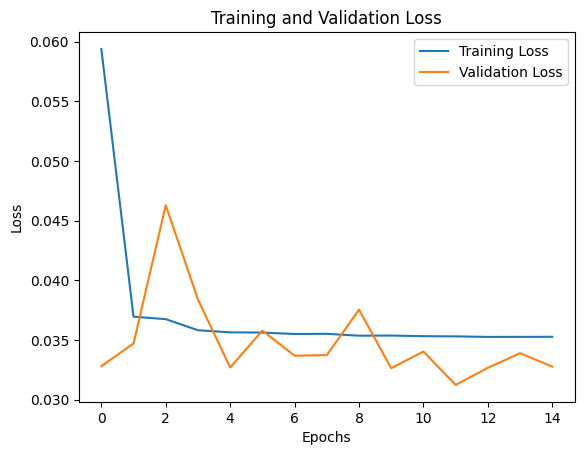

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Configuración del entrenamiento del autoencoder
callbacks = [
    ModelCheckpoint('autoencoder_data_aumentation_1.keras', verbose=1, save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(factor=0.5, patience=10, min_lr=0.00001, verbose=1)
]

history = autoencoder.fit(
    x=x_train,
    y=x_train_b,
    epochs=15,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, x_test_b),
    callbacks=callbacks
)

# Guardar el modelo entrenado
autoencoder.save('autoencoder_data_aumentation_1_global.keras')

# Evaluación del modelo en el conjunto de prueba
test_loss = autoencoder.evaluate(x_test, x_test_b)
print("Test loss (MSE):", test_loss)

# Plotting training and validation losses
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


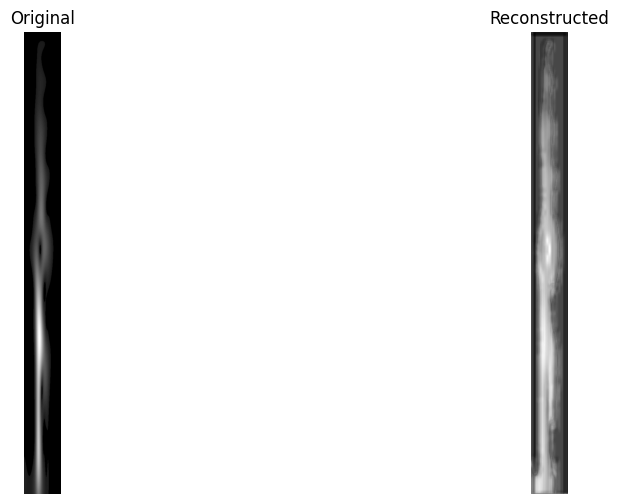

In [18]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Path to the pretrained model (HDF5 file)
model_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks_2/autoencoder_data_aumentation_1.keras"

# Path to the input image
image_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/Medidas_en_2D/train/image_1.png"

# Function to load and prepare the image
def prepare_image(img_path):
    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"The file {img_path} does not exist.")
        return None

    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image from {img_path}.")
        return None

    # Resize image to match the model's expected input dimensions
    img = cv2.resize(img, (128, 1600))  # Ensure the dimensions are correct
    img = np.array(img).astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add a channel dimension
    img = np.expand_dims(img, axis=0)  # Add a batch dimension for prediction
    return img

# Prepare the image
input_image = prepare_image(image_path)

# Load the trained autoencoder model
autoencoder = load_model(model_path)

if input_image is not None:
    # Perform prediction
    decoded_image = autoencoder.predict(input_image)

    # Display the original and reconstructed images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0].reshape(1600, 128), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image[0].reshape(1600, 128), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    plt.show()
else:
    print("The image could not be prepared, and no prediction was performed.")

75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step


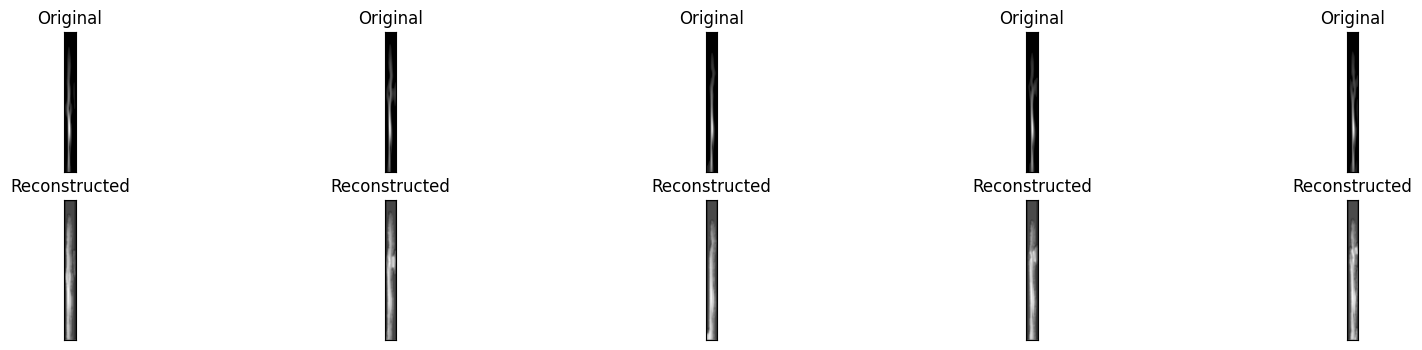

In [15]:
decoded_imgs = autoencoder.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(1600, 128), cmap='gray')
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(1600, 128), cmap='gray')
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
import numpy as np
import keras
from keras.models import load_model

x_train_autec = x_out_1601[:, 1:1601, :, :]
x_test_autec = x_out_1601_test[:, 1:1601, :, :]

# Cargar el modelo
model_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks_2/autoencoder_data_aumentation_1.keras"
model = load_model(model_path)

# Predecir usando el modelo cargado
predictions_train = model.predict(x_train_autec)
predictions_test = model.predict(x_test_autec)

# Guardar las predicciones a archivos .npy para fácil carga posterior
np.save('predictions_train.npy', predictions_train)
np.save('predictions_test.npy', predictions_test)

print("Predicciones guardadas correctamente.")

150/150 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step
Predicciones guardadas correctamente.


c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.3128 - loss: 6.8550 - val_accuracy: 0.1133 - val_loss: 2.7719
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.6676 - loss: 1.0640 - val_accuracy: 0.1688 - val_loss: 2.7715
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.7789 - loss: 0.7180 - val_accuracy: 0.1683 - val_loss: 2.7714
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.8245 - loss: 0.5525 - val_accuracy: 0.2417 - val_loss: 2.7708
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.8553 - loss: 0.4380 - val_accuracy: 0.1875 - val_loss: 2.7709
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.8824 - loss: 0.3750 - val_accuracy: 0.1833 - val_loss: 2.7708
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.8931 - loss: 0.3325 - val_accuracy: 0.2400 - val_loss: 2.7706
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.9079 -

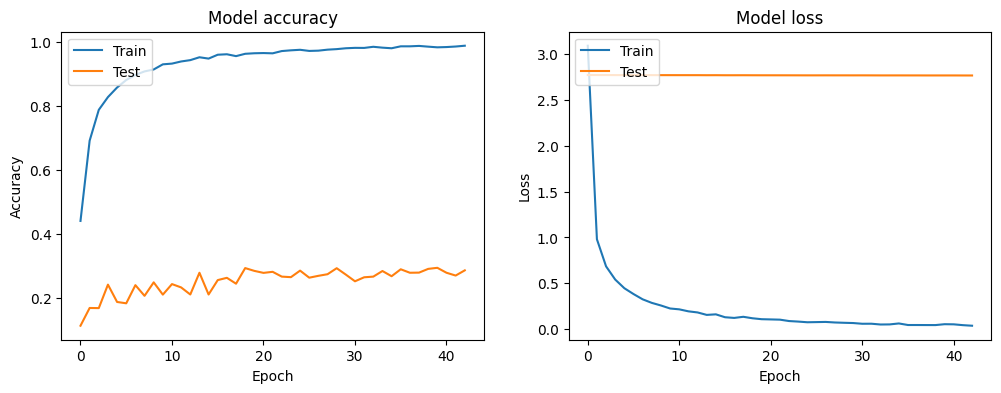

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


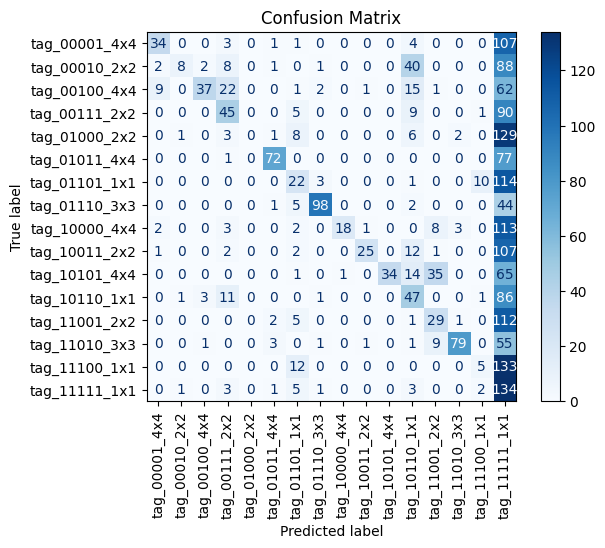

Exactitud del modelo: 28.62%
Tasa de errores: 71.38%


In [20]:
import tensorflow as tf
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=5,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=2, input_shape=(1600, 128, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    DefaultConv2D(filters=4),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=8),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=16, activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=10)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                metrics=['accuracy'])

# Train the model
history = model.fit(x_train_autec, labels_1601_categorical, epochs=100, validation_data=(x_test_autec, labels_1601_categorical_test), callbacks=[callback])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Generate predictions and plot confusion matrix
y_pred = model.predict(x_test_autec)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_1601_categorical_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.title('Confusion Matrix')
plt.show()

# Calcula y muestra la exactitud y la tasa de errores
accuracy = np.trace(cm) / np.sum(cm)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")
error_rate = 1 - accuracy
print(f"Tasa de errores: {error_rate * 100:.2f}%")

** Se puede predecir las distancias??**

In [2]:
x_out_1601 = x_out_1601.astype('float32') / 255.0
x_out_1601_test = x_out_1601_test.astype('float32') / 255.0

c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.2663 - loss: 2.3078 - val_accuracy: 0.5117 - val_loss: 1.0950
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.3893 - loss: 1.1175 - val_accuracy: 0.5213 - val_loss: 1.0090
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.4654 - loss: 1.0386 - val_accuracy: 0.5612 - val_loss: 0.8999
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5022 - loss: 0.9653 - val_accuracy: 0.5771 - val_loss: 0.8346
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5581 - loss: 0.8896 - val_accuracy: 0.5979 - val_loss: 0.8037
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5862 - loss: 0.8628 - val_accuracy: 0.6012 - val_loss: 0.8023
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5981 - loss: 0.8371 - val_accuracy: 0.6179 - val_loss: 0.7799
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.6193 - loss:

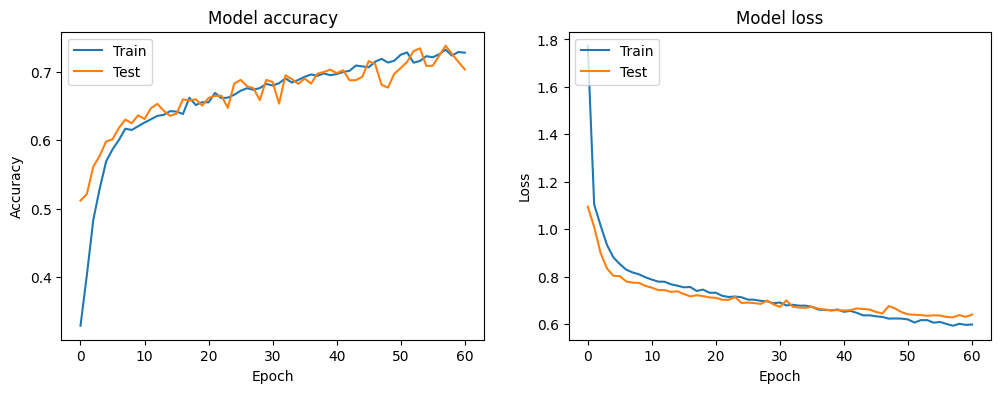

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


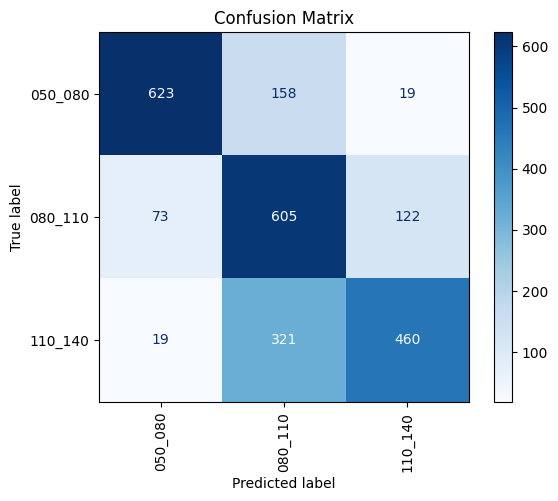

Exactitud del modelo: 70.33%
Tasa de errores: 29.67%


In [3]:
import tensorflow as tf
from functools import partial
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert string labels to numerical intervals
intervals_encoder = LabelEncoder()
intervals_1601_categorical = intervals_encoder.fit_transform(intervals)
intervals_1601_categorical_test = intervals_encoder.transform(test_intervals_1601)

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=5,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=2, input_shape=(1601, 128, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    DefaultConv2D(filters=4),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=8),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=16, activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=10)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                metrics=['accuracy'])

# Train the model
history = model.fit(x_out_1601, intervals_1601_categorical, epochs=100, 
                    validation_data=(x_out_1601_test, intervals_1601_categorical_test), callbacks=[callback])


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Generate predictions and plot confusion matrix
y_pred = model.predict(x_out_1601_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(intervals_1601_categorical_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=intervals_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.title('Confusion Matrix')
plt.show()

# Calcula y muestra la exactitud y la tasa de errores
accuracy = np.trace(cm) / np.sum(cm)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")
error_rate = 1 - accuracy
print(f"Tasa de errores: {error_rate * 100:.2f}%")

In [4]:
model.predict(x_out_1601_ref)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)